# Helper methods

Execute methods in this section one by one.

After doing so you can safely collapse this block as it contains additional methods, required for the excersies.

In [39]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

from tqdm import tqdm
from IPython.display import clear_output

In [2]:
def load_image(path, is_grayscale = False):
    """Loads an image from hard drive using the given path.
    """
    if is_grayscale:
        return cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    return cv2.imread(path)

In [44]:
def show_image(*images):
    """Shows the list of images side-by-side.
    """
    n = len(images)
    fig, axes = plt.subplots(ncols=n, nrows=1)

    if n == 1:
        axes.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
    else:
        for i in range(n):
            axes[i].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))

In [4]:
def convert_to_grayscale(image):
    """Converts the given image to the greyscale.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [5]:
def __fast_convolve(image, kernel):
    """Applies kernel to the given image.
    """
    image_fft = np.fft.rfft2(image)
    kernel_fft = np.fft.rfft2(kernel,image.shape)
    return np.fft.irfft2(image_fft*kernel_fft)

def get_edges(image):
    """Finds image edges.
    """
    sx = np.array([[ 1, 2, 1],
                   [ 0, 0, 0],
                   [-1,-2,-1]])
    
    sy = np.array([[ 1, 0, -1],
                   [ 2, 0, -2],
                   [ 1, 0, -1]])
    
    edge_horizontal = __fast_convolve(image, sx)
    edge_vertical = __fast_convolve(image, sy)
    
    return np.sqrt(np.square(edge_horizontal) + np.square(edge_vertical))

In [6]:
def calculate_cost(image_edges):
    """Calculates energy/cost of the edges.
       In other words, this function finds areas with interesting
       objects in it.
    """
    r, c = image_edges.shape
    cost = np.zeros(image_edges.shape)
    cost[r-1,:] = image_edges[r-1,:]
    
    for i in range(r-2,-1,-1):
        for j in range(c):
            c1,c2 = max(j-1,0),min(c,j+2)
            cost[i][j] = image_edges[i][j] + cost[i+1,c1:c2].min()
                
    return cost

In [7]:
def find_seam(image_cost):
    """Finds seam (path) with the minimum energy/cost.
    """
    r, c = image_cost.shape
    
    seam = []
    j = image_cost[0].argmin()
    seam.append(j)
    
    for i in range(r-1):
        c1,c2 = max(j-1,0),min(c,j+2)
        j = max(j-1,0)+image_cost[i+1,c1:c2].argmin()
        seam.append(j)

    return seam

In [8]:
def remove_seam(image, seam):
    """Removes the given seam from the image.
    """
    r, c, _ = image.shape
    new_image = np.zeros((r,c,3))

    for i, j in enumerate(seam):
        new_image[i,0:j,:] = image[i,0:j,:]
        new_image[i,j:c-1,:] = image[i,j+1:c,:]
    return new_image[:,:-1,:].astype(np.uint8)

In [9]:
def draw_seam(image, seam):
    """Draws the given seam on the given image.
       Comes handy for debugging seams.
    """
    image_canvas = np.copy(image)
    image_canvas[range(len(seam)),seam,:] = np.array([255,0,0])
    return image_canvas

In [43]:
def horizontal_seam_carving(image, dw):
    """Horizontal content-aware image resizing.
       Horizontal means that the methods removes columns of the image.
    """
    carved_image = np.copy(image) 
    for i in tqdm(range(0, dw), desc="Seam carving"):
        carved_image = horizontal_seam_carving_one_step(carved_image)
        clear_output(wait=True)
    return carved_image

In [11]:
def vertical_seam_carving(image, dh):
    """Vertical content-aware image resizing.
       Vertical means that the methods removes rows of the image.
    """
    carved_image = np.copy(image)
    carved_image = carved_image.transpose(1, 0, 2)
    carved_image = horizontal_seam_carving(carved_image, dh)
    carved_image = carved_image.transpose(1, 0, 2)
    return carved_image

# Exercise 1: Center Crop

You need to implement a center crop algorithm.

The method should accept an image and desired width and height. Your task is to return a modified image with new sizes.

You may assume that desired width and height are **smaller** than the origin image sizes.

## Helpful methods
- **image.shape**: returns a tuple of image dimensions (height, width, and channels)
    - **shape[0]**: height
    - **shape[1]**: width
- **image[y0:y1, x0:x1]**: extracts a rectangular patch from the image where **x0 to x1** corresponds to horizontal axis and **y0 to y1** to vertical.
- **cv2.resize(image, (new_width, new_height))**: resizes the entire image (all content) to the **new_width** and **new_height**

## Example: top left crop

Rectangular crop starting in top-left corner.

In [12]:
def crop_topleft(image, desired_width, desired_height):
    y0 = 0
    y1 = 0 + desired_height

    x0 = 0
    x1 = 0 + desired_width
    
    return image[y0:y1, x0:x1]

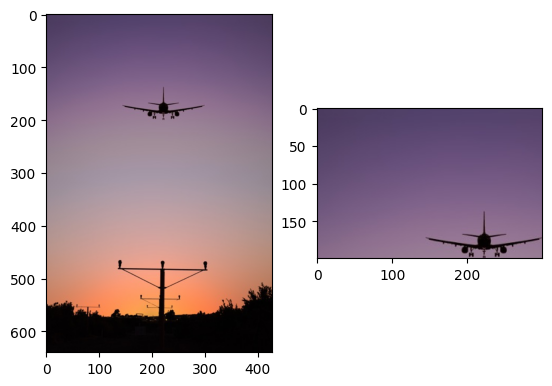

In [13]:
image = load_image("images/plane_4.jpeg")
show_image(image, crop_topleft(image, desired_width=300, desired_height=200))

In [ ]:
def crop_center(image, desired_width, desired_height):
    # (1 line of code)
    # shape = ...

    height = shape[0]
    width = shape[1]

    # (2 lines of code)
    # vertical_offset = (height - ...) // 2
    # horizontal_offset = (width - ...) // 2

    # (2 lines of code)
    y0 = vertical_offset
    # y1 = y0 + ...

    x0 = horizontal_offset
    # x1 = x0 + ...

    return image[y0:y1, x0:x1]

## Testing

Call a method with an image and you should see a resized version of the image.

Original image shape (height, width, channels): (640, 427, 3)
Resized image shape (height, width, channels): (350, 350, 3)


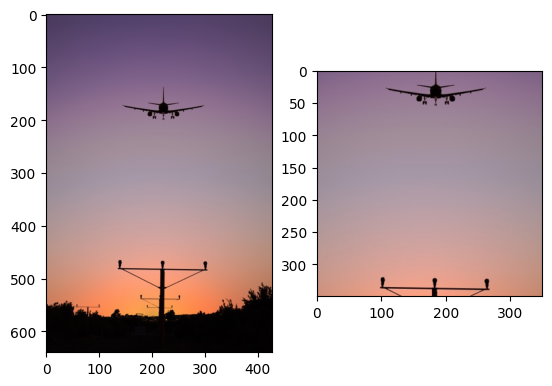

In [20]:
image = load_image("images/plane_4.jpeg")
print('Original image shape (height, width, channels):', image.shape)
resized_image = crop_center(image, desired_width = 350, desired_height = 350)
print('Resized image shape (height, width, channels):', resized_image.shape)
show_image(image, resized_image)

# Exercise 2: Channels Extraction

You need to separate 3 color channels from the given image and figure out their respective ordering.

The channels indicies are **0, 1, and 2**.

Grayscale image shape (427, 640)
3-channels image shape (427, 640, 3)


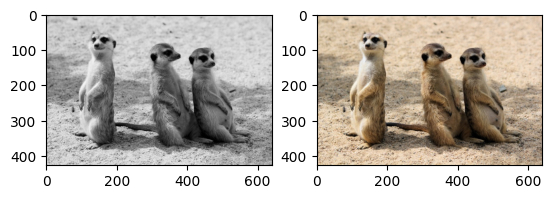

In [23]:
grayscale_image = load_image('images/animal_1.jpeg', is_grayscale=True)
rgb_image = load_image('images/animal_1.jpeg', is_grayscale=False)

print("Grayscale image shape", grayscale_image.shape)
print("3-channels image shape", rgb_image.shape)

show_image(grayscale_image, rgb_image)

In [27]:
def extract_channel(image, channel):
    assert channel in [0, 1, 2], \
        f"Channel {channel} is unsupported."

    # (1 line of code)
    # shape = ...

    # Shape is a tuple (height, width, channels)
    channels = shape[2]
    assert channels == 3, \
        "Only images with 3 channels are supported."

    image_copy = np.copy(image)
    for i in range(3):
        if i != channel:
            image_copy[:, :, i] = 0

    return image_copy

## Testing

Run the cell below to extract channels 0, 1, and 2.

In [ ]:
show_image(extract_channel(rgb_image, 0), extract_channel(rgb_image, 1), extract_channel(rgb_image, 2))

# Exercise 3: Seam Carving 


You need to implement **one step** of seam carving algorithm. 
In other words, we need to **remove only 1 vertical column** from the image.

Remember the steps that we discussed during the lecture:
1. Convert image to grayscale
2. Find edges
3. Calculate energy function (aka cost function)
4. Find a seam (aka path from top to bottom) with the minimal energy
5. Remove the seam from the image
6. Return the image

## General methods

1. `convert_to_grayscale(img)`: converts a bgr image to grayscale
2. `get_edges(grayscale_image)`: extracts edges from a grayscale image
3. `calculate_cost(edges)`: calculates energy (aka cost) matrix
4. `find_seam(cost_matrix)`: returns a seam with min energy
5. `remove_seam(img, seam)`: removes the **seam** from the **image**

## Debug methods

1. `draw_seam(img, seam)`: draws a seam on the image (instead of removing it), may come handy during debugging

In [ ]:
def horizontal_seam_carving_one_step(image, is_debug=False):
    # Convert to grayscale and detect edges on the image.
    # (2 lines of code)
    # grayscale_image = ...
    # edges = ...

    cost_matrix = calculate_cost(edges)
    # This is your seam, i.e. the least interesting path from one side of the image to another one.
    seam = find_seam(cost_matrix)

    if is_debug:
        # Drawing the seam and returning an image.
        # (1 line of code)
        # return ...

    # Remove the seam from the image.
    # (1 line of code)
    # return ...

## Running One Step of Seam Carving

Let's take a look at one step of the algorithm.

To highlight the seam instead of removing it, we can call the method we've just implemmented with `is_debug=True` argument.

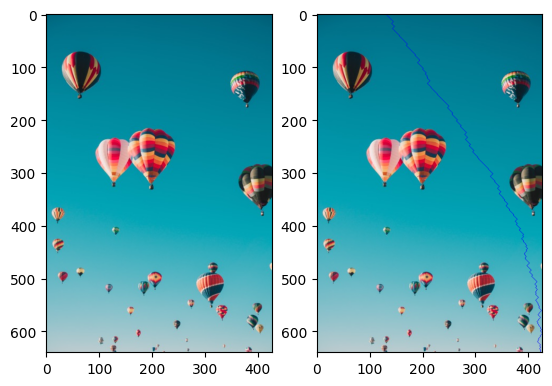

In [52]:
original_image = load_image("images/balloons_2.jpeg")
debug_seam_carving_step_image = horizontal_seam_carving_one_step(original_image, is_debug=True)
show_image(original_image, debug_seam_carving_step_image)

## Running Seam Carving

When we verified that one step is running just fine, we can try to run more steps.

### Helpful methods
- `vertical_seam_carving(img, dh)`: carves out `dh` rows from the `img`
- `horizontal_seam_carving(img, dw)`: carves out `dw` columns from the `img`

Seam carving: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.02it/s]

CPU times: user 49.3 s, sys: 434 ms, total: 49.7 s
Wall time: 49.7 s


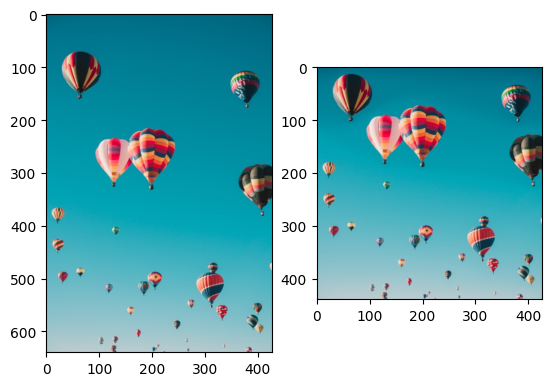

In [47]:
%%time
# This is a function to test your code. Replace the image with any image you want.
original_image = load_image("images/balloons_2.jpeg")
show_image(original_image, vertical_seam_carving(original_image, 200))

Seam carving: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:49<00:00,  4.08it/s]


CPU times: user 48.6 s, sys: 427 ms, total: 49 s
Wall time: 49 s


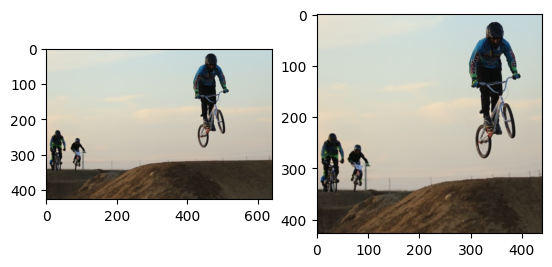

In [48]:
%%time
# This is a function to test your code. Replace the image with any image you want.
original_image = load_image("images/cyclists_1.jpeg")
show_image(original_image, horizontal_seam_carving(original_image, 200))